In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**About the Dataset:**

I used a dataset on Algerian Forest Fires from UCI. The dataset contains a culmination of forest fire observations and data in two regions of Algeria: the Bejaia region and the Sidi Bel-Abbes region. The timeline of this dataset is from June 2012 to September 2012. In this project, we focused on whether certain weather features could predict forest fires in these regions using few Classification algorithms.

**Attribute Information:**

1. Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012) Weather data observations
2. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
RH : Relative Humidity in %: 21 to 90
3. Ws :Wind speed in km/h: 6 to 29
4. Rain: total day in mm: 0 to 16.8 FWI Components
5. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
6. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
7. Drought Code (DC) index from the FWI system: 7 to 220.4
8. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
9. Buildup Index (BUI) index from the FWI system: 1.1 to 68
10. Fire Weather Index (FWI) Index: 0 to 31.1
11. Classes: two classes, namely Fire and not Fire


Exploratory Data Analysis of the dataset

In [2]:
#load in the data
df = pd.read_csv('/content/drive/MyDrive/Projects/Forest Fire Weather Index Prediction /Algerian_forest_fires_cleaned_dataset.csv')

# Strip mispaced values
df.Classes = df.Classes.str.strip()


In [ ]:
#Droping year features
df1 = df.drop(['day','month','year'], axis=1)

## categories in classes
df1['Classes'].value_counts()


,count
Classes,
fire,137
not fire,106


In [ ]:
## Encoding of the categories in classes
df1['Classes']=np.where(df1['Classes'].str.contains('not fire'),0,1)

#check counts
df1['Classes'].value_counts()


,count
Classes,
1,137
0,106


In [ ]:
df1.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0


Density Distribution Visualization

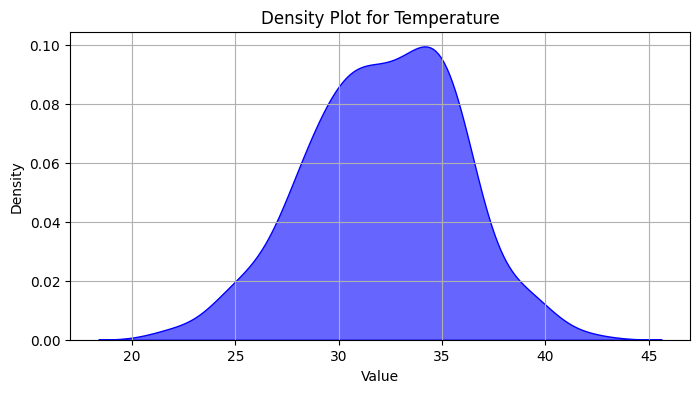

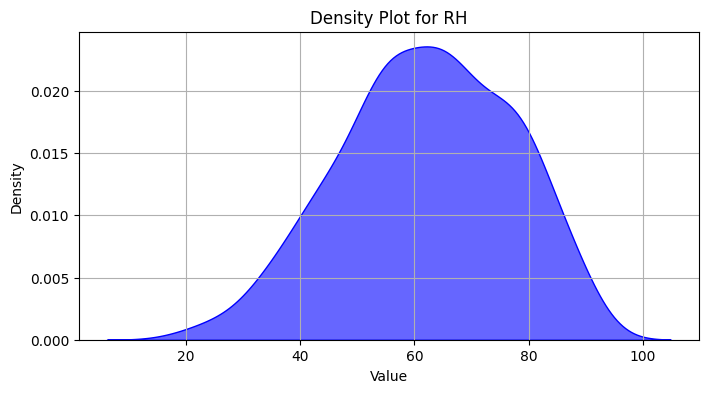

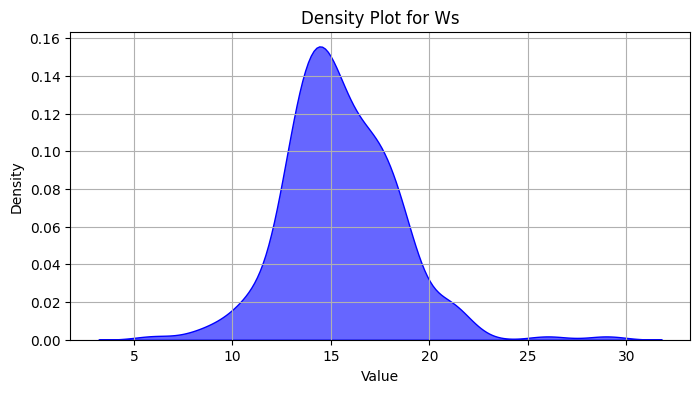

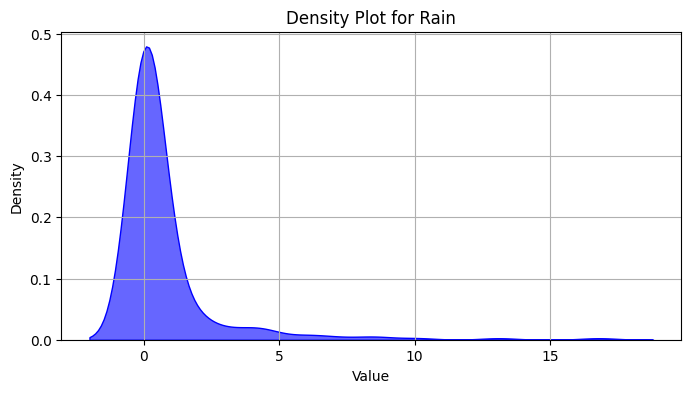

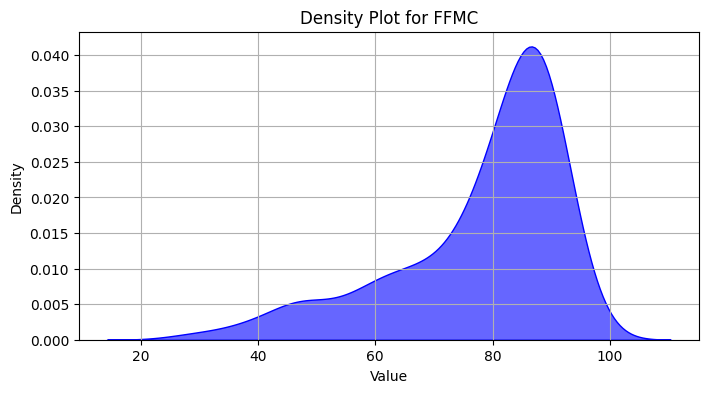

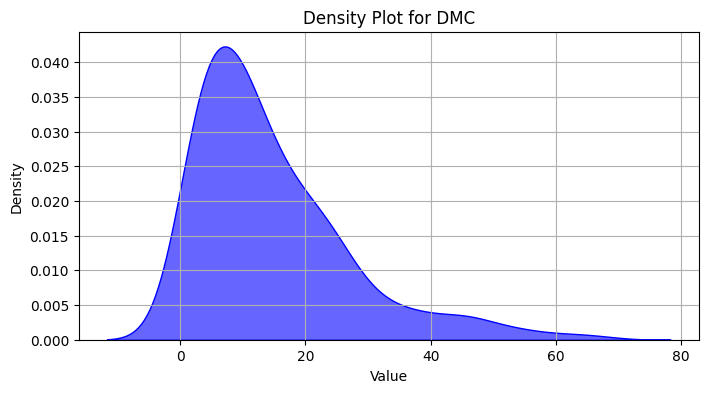

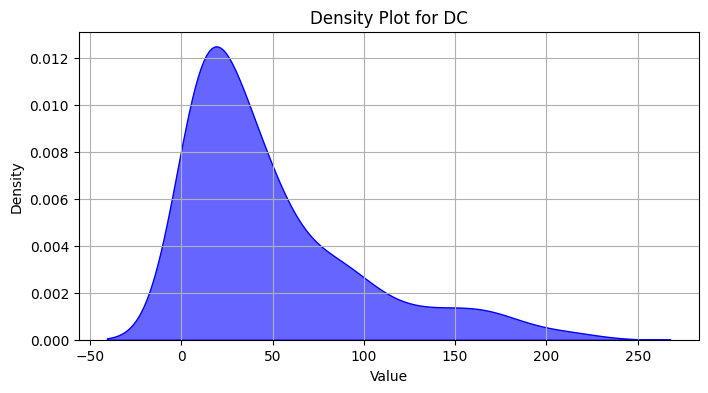

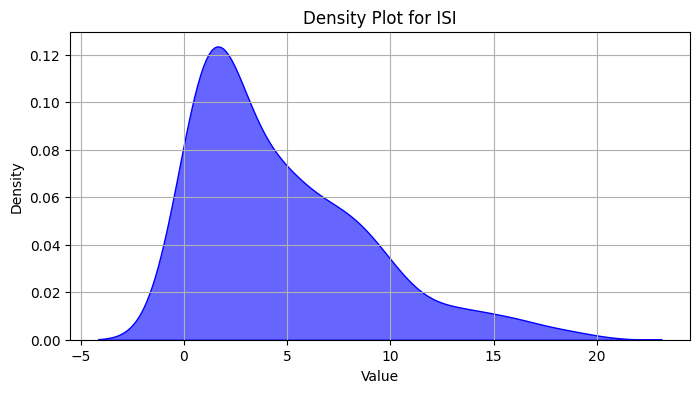

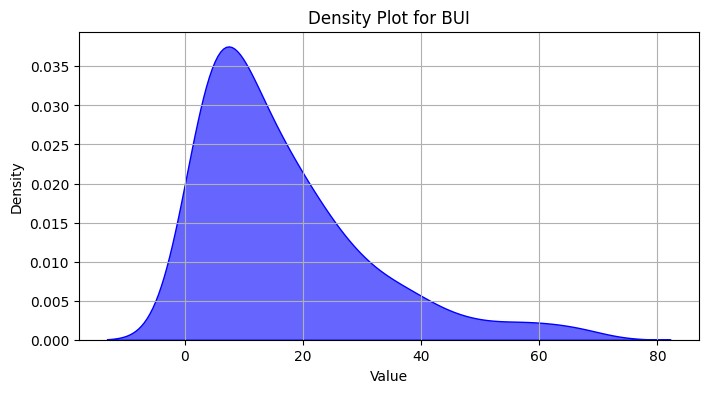

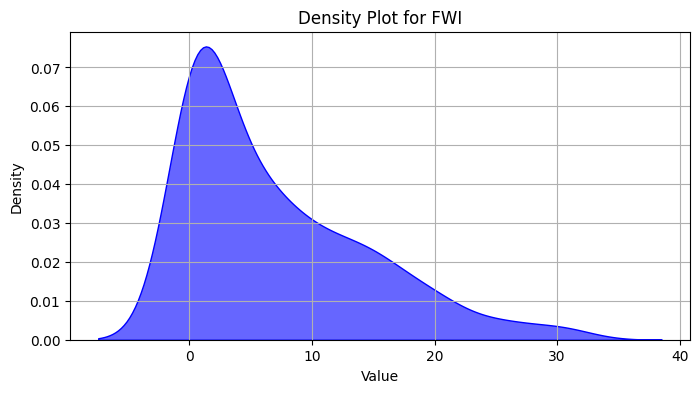

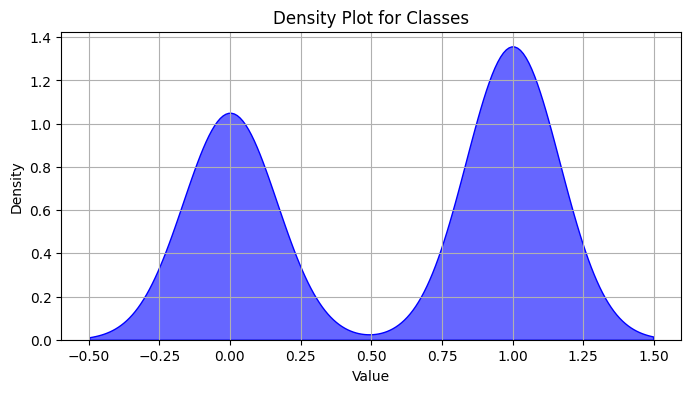

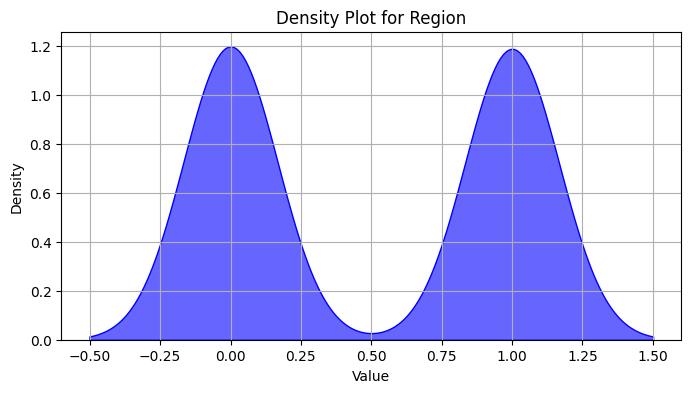

In [ ]:
# Select numerical columns
numerical_columns = df1.select_dtypes(include=['float64', 'int64']).columns

# Plot density plot for each feature
for column in numerical_columns:
    plt.figure(figsize=(8, 4))  # Set figure size
    sns.kdeplot(df1[column], fill=True, color='blue', alpha=0.6)
    plt.title(f'Density Plot for {column}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [ ]:
# Percentage for PieChart
percentage = df1.Classes.value_counts(normalize=True)*100
percentage

,proportion
Classes,
1,56.378601
0,43.621399


Pie Chart: Fire vs No Fire

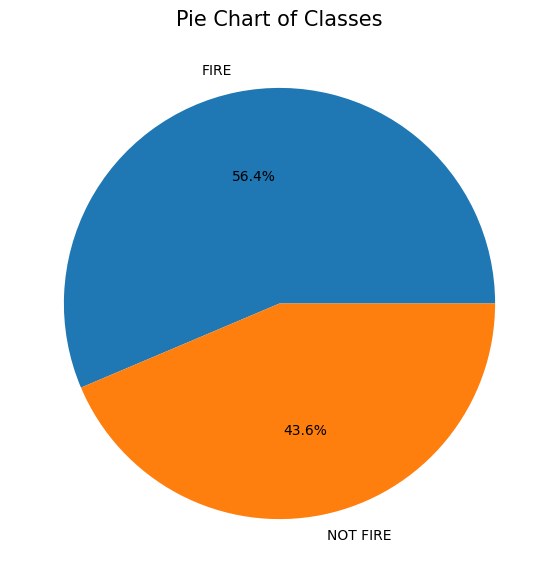

In [ ]:
#Plot PieChart
classeslabels = ["FIRE", "NOT FIRE"]
plt.figure(figsize =(12, 7))
plt.pie(percentage,labels = classeslabels,autopct='%1.1f%%')
plt.title ("Pie Chart of Classes", fontsize = 15)
plt.show()

In [ ]:
corr = df1.corr()

Checking Multicollinearity

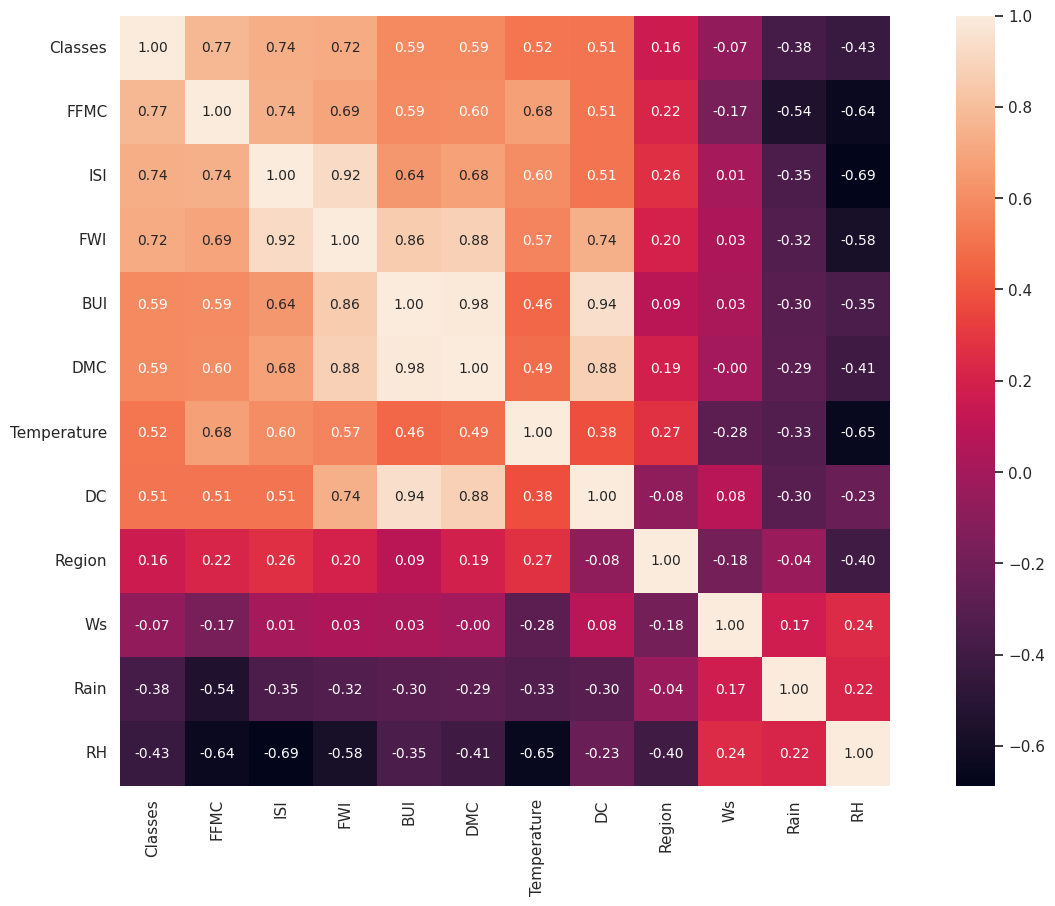

In [ ]:
# Correlation chart
k = len(df1.columns)
cols = corr.nlargest(k, 'Classes')['Classes'].index
cm = np.corrcoef(df1[cols].values.T)
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(17, 10))
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

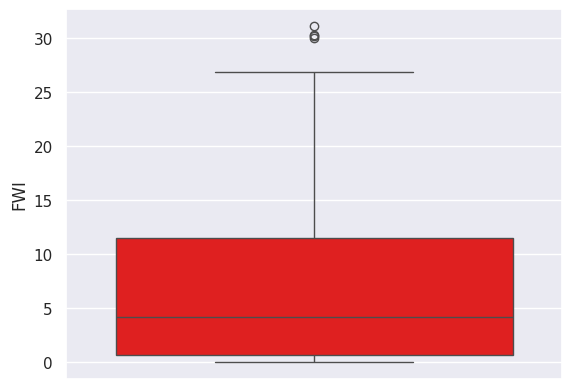

In [ ]:
#Boxplot od FWI that can be used
ax = sns.boxplot(df1['FWI'], color= 'red')

**Monthwise Fire Analysis**

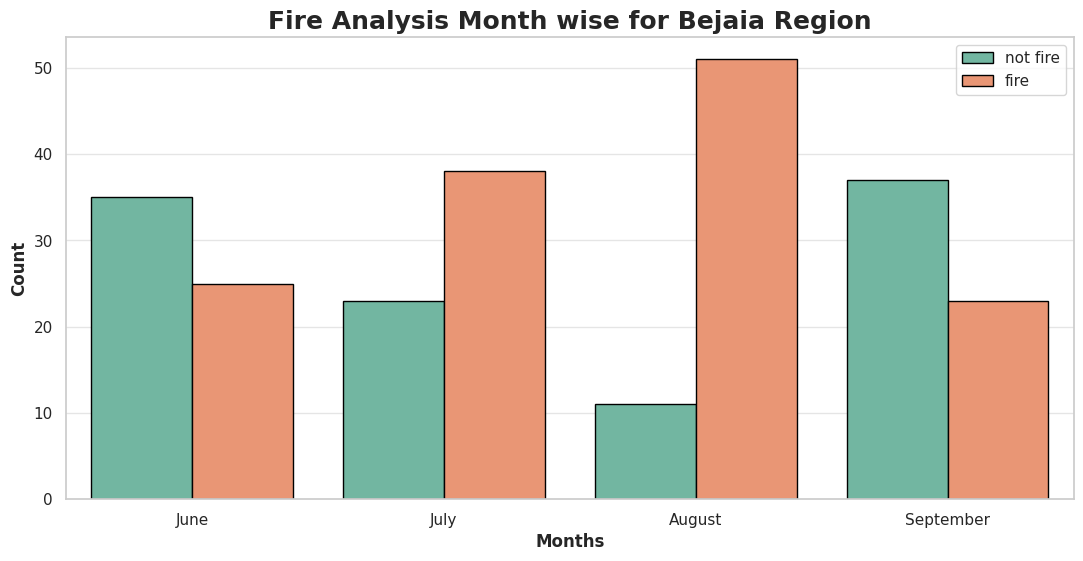

In [ ]:
dftemp= df1.loc[df1['Region']== 1]
plt.subplots(figsize=(13,6))
sns.set_style('whitegrid')
sns.countplot(x='month',hue='Classes',data= df,ec = 'black', palette= 'Set2')
plt.title('Fire Analysis Month wise for Bejaia Region', fontsize=18, weight='bold')
plt.ylabel('Count', weight = 'bold')
plt.xlabel('Months', weight= 'bold')
plt.legend(loc='upper right')
plt.xticks(np.arange(4), ['June','July', 'August', 'September',])
plt.grid(alpha = 0.5,axis = 'y')
plt.show()

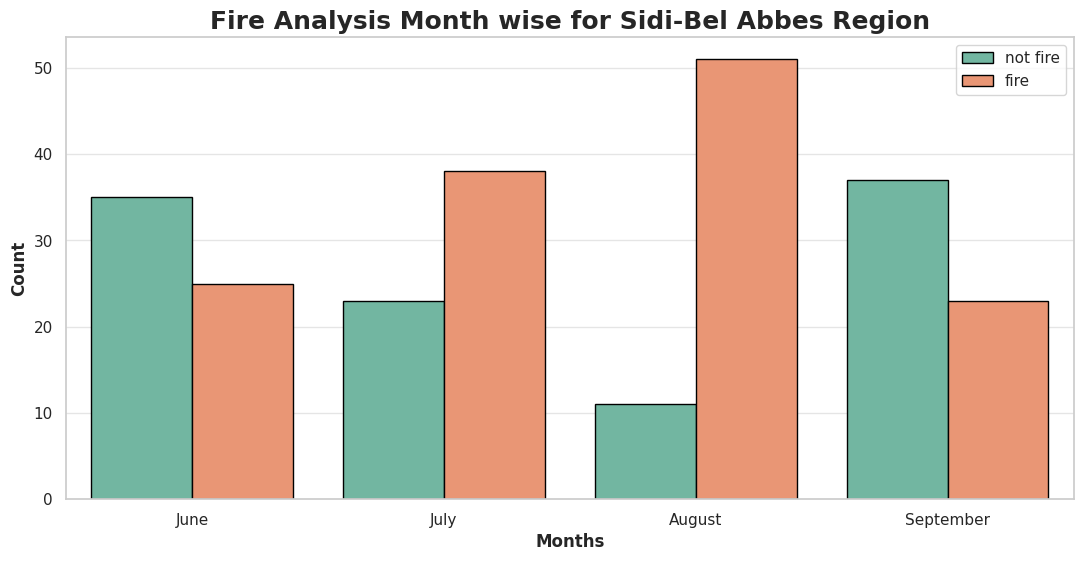

In [ ]:
dftemp= df.loc[df['Region']== 2]
plt.subplots(figsize=(13,6))
sns.set_style('whitegrid')
sns.countplot(x='month',hue='Classes',data= df,ec = 'black', palette= 'Set2')
plt.title('Fire Analysis Month wise for Sidi-Bel Abbes Region', fontsize=18, weight='bold')
plt.ylabel('Count', weight = 'bold')
plt.xlabel('Months', weight= 'bold')
plt.legend(loc='upper right')
plt.xticks(np.arange(4), ['June','July', 'August', 'September',])
plt.grid(alpha = 0.5,axis = 'y')
plt.show()

In [ ]:
def barchart(feature, xlabel, bins=None):
    plt.figure(figsize=[12, 6])

    # Bin the feature if bins are specified
    if bins:
        df1['binned_feature'] = pd.cut(df1[feature], bins=bins)
        grouped = df1.groupby('binned_feature', as_index=False)['Classes'].sum()
        x = 'binned_feature'
    else:
        grouped = df1.groupby(feature, as_index=False)['Classes'].sum()
        x = feature

    # Create the bar plot
    ax = sns.barplot(x=x, y='Classes', data=grouped, color='skyblue', edgecolor='black')

    # Set axis labels and title
    ax.set(xlabel=xlabel, ylabel='Fire Count')
    plt.title(f'Fire Count by {xlabel}', fontsize=16)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()
    plt.show()


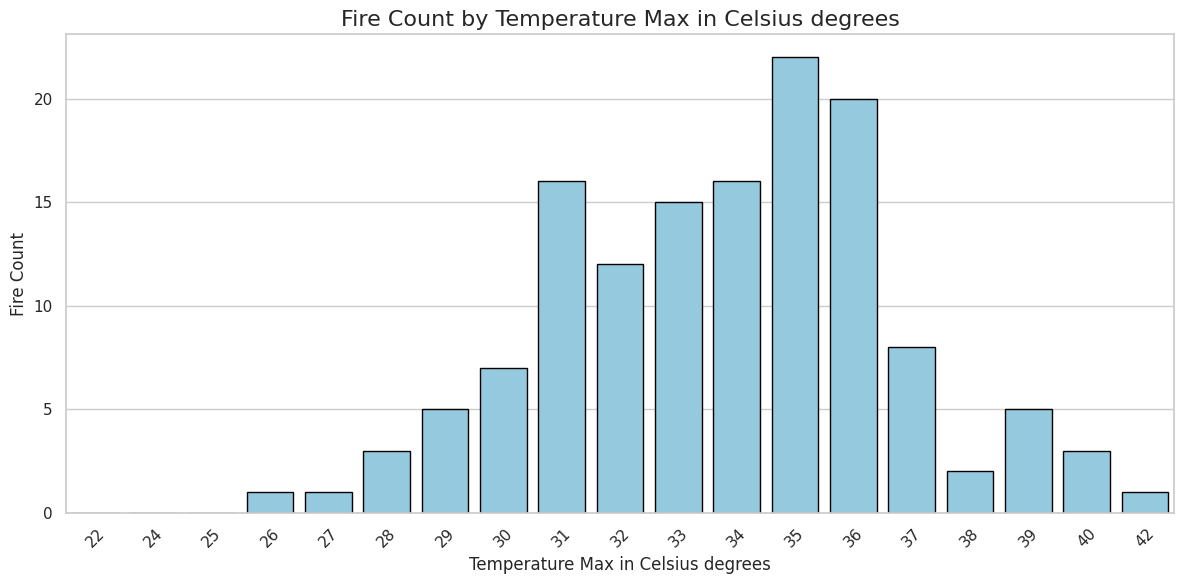

In [ ]:
#barchart for temp
barchart('Temperature', 'Temperature Max in Celsius degrees')

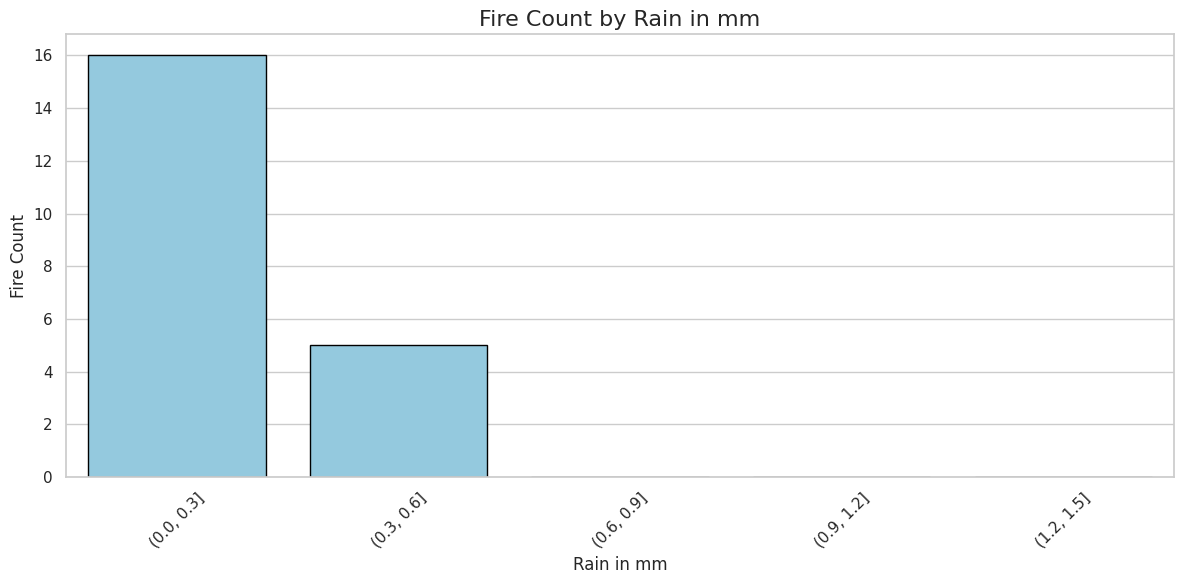

In [ ]:
rain_bin = [0, 0.3, 0.6,  0.9, 1.2, 1.5]
barchart('Rain', 'Rain in mm', bins=rain_bin)

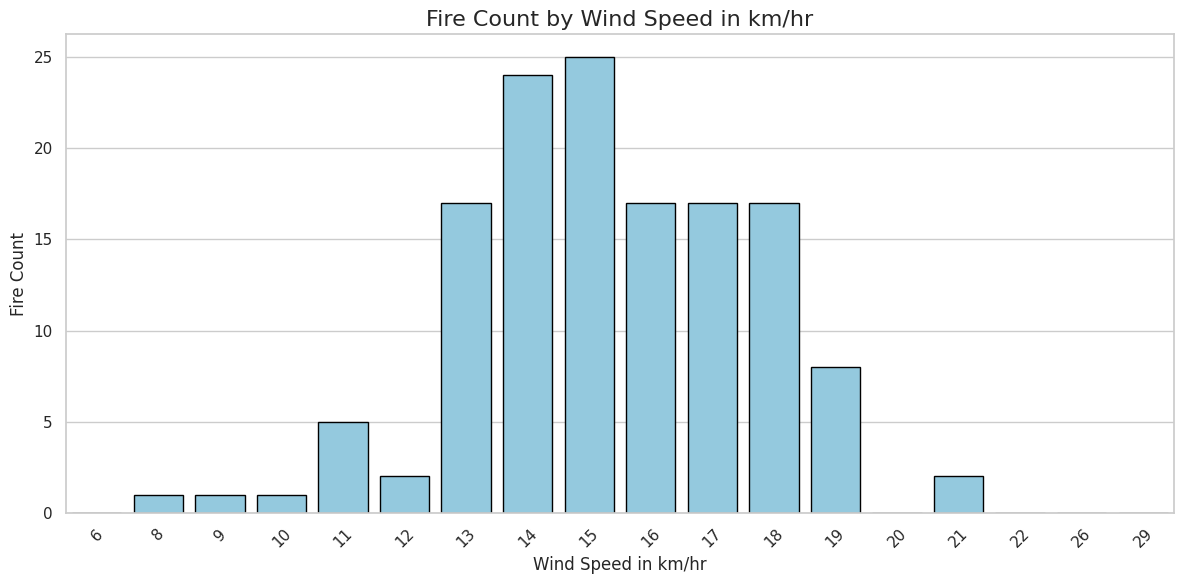

In [ ]:
barchart('Ws', 'Wind Speed in km/hr')

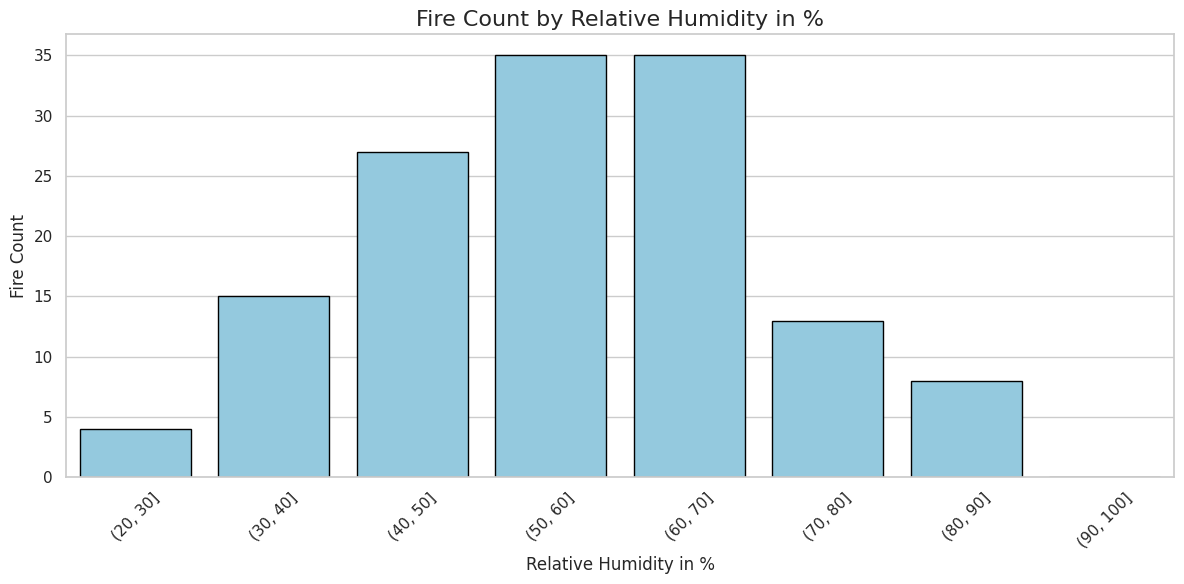

In [ ]:
humidity_bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]
barchart('RH','Relative Humidity in %', bins = humidity_bins)

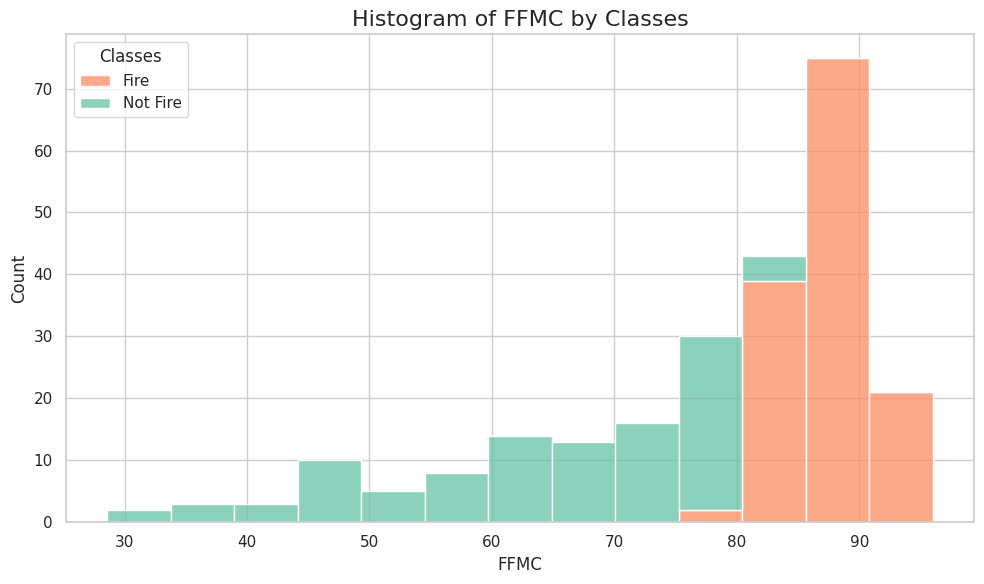

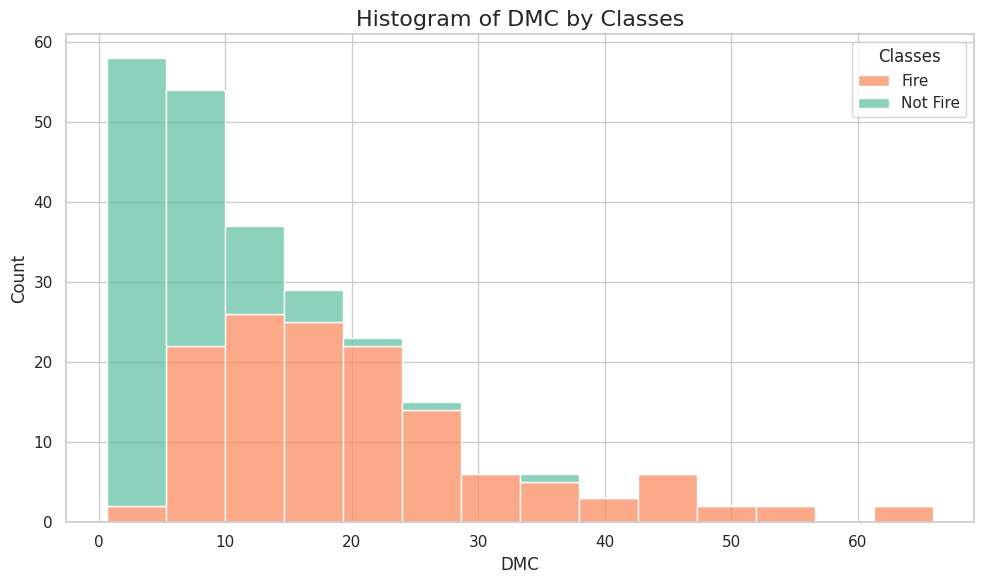

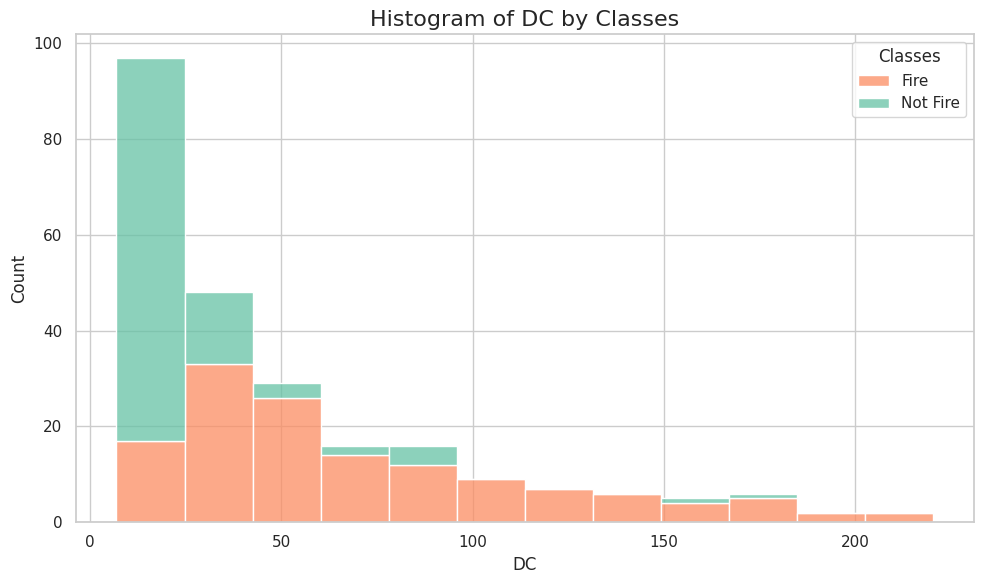

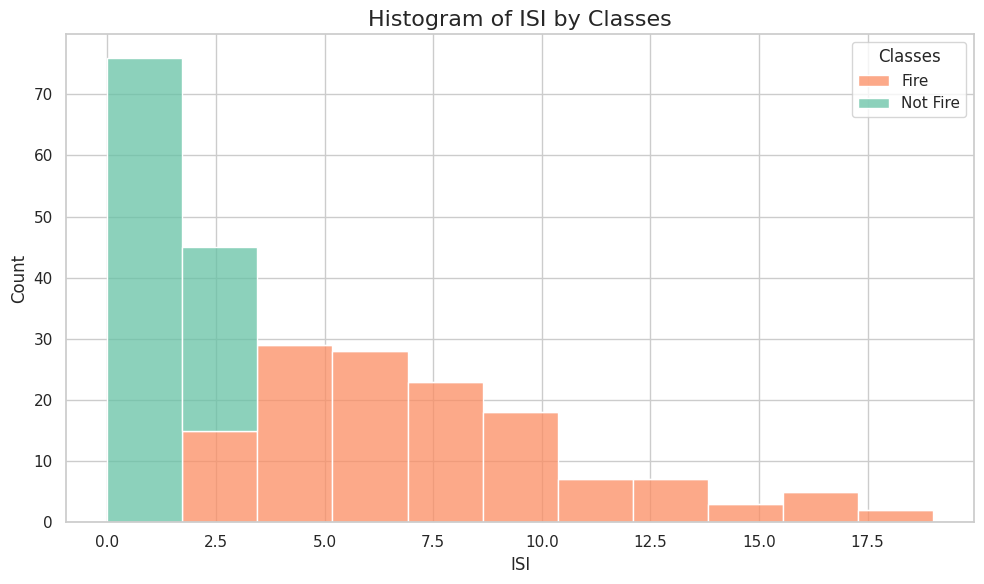

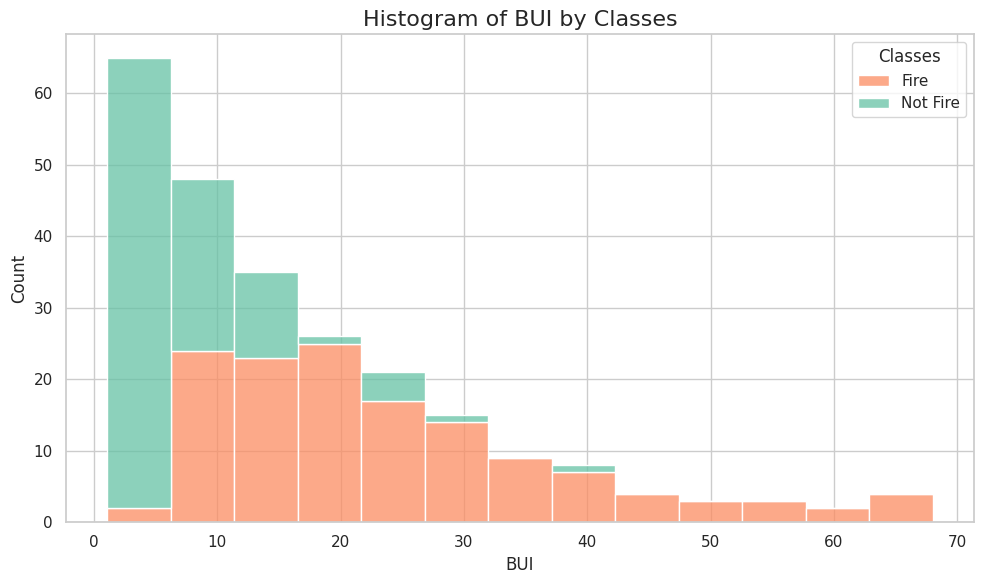

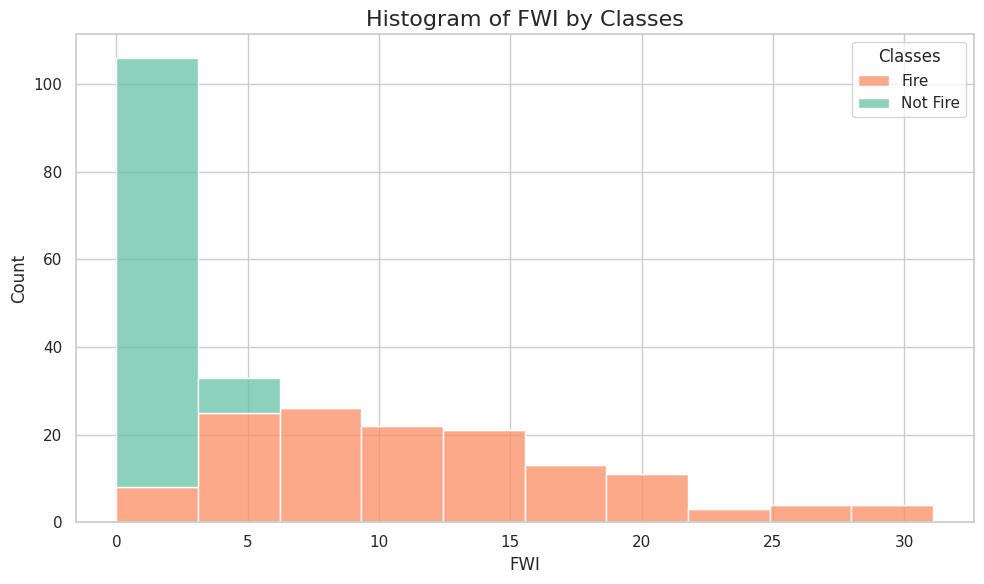

In [ ]:
# Drop unnecessary columns
dftemp = df.drop(['Region', 'Temperature', 'Rain', 'Ws', 'RH', 'day', 'year', 'month'], axis=1)

# Loop through each feature in the DataFrame
for feature in dftemp.columns:
    if feature != 'Classes':  # Skip the 'Classes' column
        plt.figure(figsize=(10, 6))
        sns.histplot(data=dftemp, x=feature, hue='Classes', kde=False, multiple='stack', palette='Set2')
        plt.title(f'Histogram of {feature} by Classes', fontsize=16)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.legend(labels=['Fire', 'Not Fire'], title='Classes')
        plt.tight_layout()
        plt.show()


**REPORT**

*Weather System Report*
Fire Count is the highest when
- Temperature is between 30-37 degree Celsius
- Rain is 0.0mm to 0.6mm.
- Wind Speeds were between 13 to 19 Km/hr.
- RH is between 50 to 80%.

*FWI (Canadian Forest Fire Weather Index) System Components Report*

- **Fine Fuel Moisture Code (FFMC)** index ranges bewtween 28.6 - 92.5

 **+75 FFMC** has higher chance of Forest fires.

- **Duff Moisture Code (DMC)** index ranges between 1.1 - 65.9
  
  1.1-10 has lower chance of Forest fires
  
  **+10-30 DMC** has very high evidence of Forest fires in past

-  **Drought Code (DC)**  index ranges between 7 to 220.4
  
  0-25 is safe and has lower chance of Forest fires
  
  **+25 DC** has higher chance of forest fires

- Initial Spread Index (ISI) index ranges between 0 to 18

   0-3 has lower Forest fires
   
   **+3 ISI** has higher chance of Forest fires.

- Buildup Index (BUI) index ranges between 1.1 to 68

  1.1 to 10 has lower Forest fire chance

  **10 BUI** has higher chance of forest fires.

- Fire Weather Index (FWI) Index ranges between 1 to 31.1

  0-3 has lower chance of Forest fires

  **3-25 FWI** has higher chance of forest fires.

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,1,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,1,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,1,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,1,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
238,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1,1
239,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,1,1
240,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,1,1
241,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,1,1


Model Training and Testing

In [3]:
df.drop(['day','month','year'], axis=1, inplace=True)

# Encoding Not fire as 0 and Fire as 1
df['Classes']= np.where(df['Classes']== 'not fire',0,1)

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score

X = df.drop('FWI',axis=1)
y= df['FWI']

# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
X_train.shape, X_test.shape

((182, 11), (61, 11))

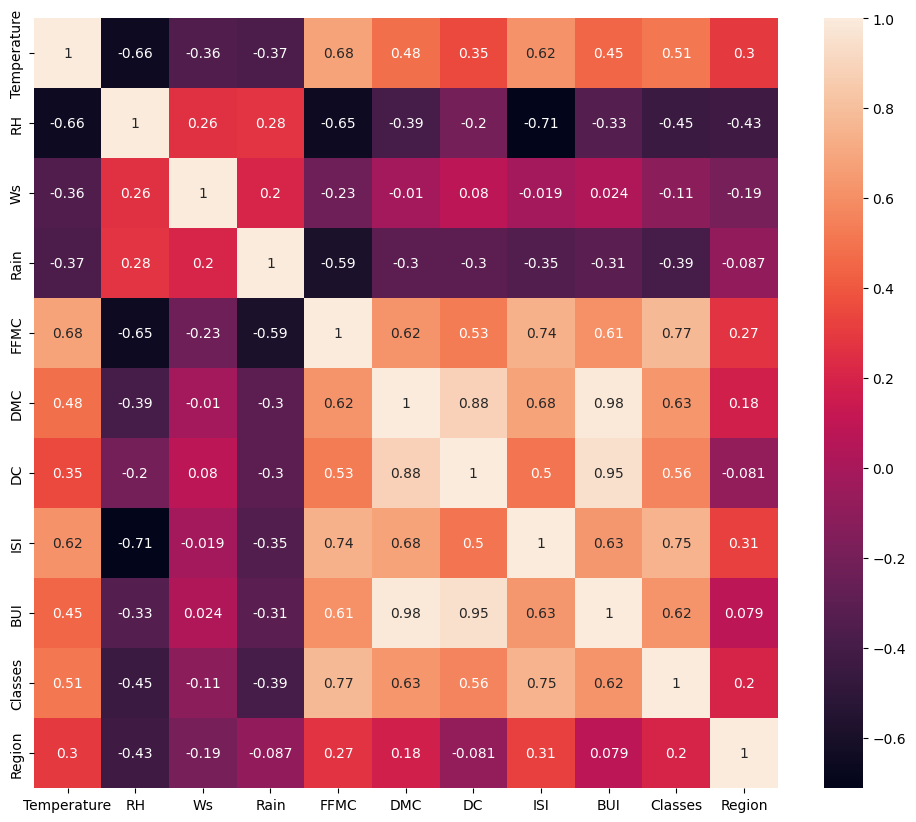

In [5]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [6]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

# drop features which has correlation more than 0.75
corr_features = correlation(X_train, 0.75)
X_train.drop(corr_features,axis=1, inplace=True)
X_test.drop(corr_features,axis=1, inplace=True)
X_train.shape, X_test.shape

((182, 8), (61, 8))

In [7]:
#Feature scaling
def scaler_standard(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled


X_train_scaled, X_test_scaled = scaler_standard(X_train, X_test)

Linear Regreesion

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression")
print ("R2 Score value: {:.4f}".format(r2))
print ("MAE value: {:.4f}".format(mae))


Linear Regression
R2 Score value: 0.9700
MAE value: 0.6453


Lasso Regression

In [9]:
from sklearn.linear_model import Lasso


lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

#predict and evaluate
lasso_pred = lasso.predict(X_test_scaled)
mae = mean_absolute_error(y_test, lasso_pred)
r2 = r2_score(y_test, lasso_pred)


print("Lasso Regression")
print ("R2 Score value: {:.4f}".format(r2))
print ("MAE value: {:.4f}".format(mae))

Lasso Regression
R2 Score value: 0.9377
MAE value: 1.1209


KNN

In [10]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)

#predict and evaluate
knn_pred = knn.predict(X_test_scaled)
mae = mean_absolute_error(y_test, knn_pred)
r2 = r2_score(y_test, knn_pred)


print("K_Neighbours Regressor")
print ("R2 Score value: {:.4f}".format(r2))
print ("MAE value: {:.4f}".format(mae))

K_Neighbours Regressor
R2 Score value: 0.9422
MAE value: 0.9816


Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

#predict and evaluate
rf_pred = rf.predict(X_test_scaled)
mae = mean_absolute_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)


print("Random Forest Regressor")
print ("R2 Score value: {:.4f}".format(r2))
print ("MAE value: {:.4f}".format(mae))

Random Forest Regressor
R2 Score value: 0.9774
MAE value: 0.5971


Random Forest Performed the best out of all the models, therefore

**Hyperparameter Tuning for Random Forest**

In [13]:
param_grid =[{'bootstrap': [True, False],
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,120],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [1, 3, 4],
'min_samples_split': [2, 6, 10],
'n_estimators': [5, 20, 50, 100]}]

f_reg = RandomForestRegressor()
Random_rf = RandomizedSearchCV(f_reg,param_grid, cv = 10, verbose=2,n_jobs = -1)
Random_rf.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100, 110,
                                                       120],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 3, 4],
                                         'min_samples_split': [2, 6, 10],
                                         'n_estimators': [5, 20, 50, 100]}],
                   verbose=2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits

In [14]:
best_random_grid=Random_rf.best_estimator_

bestrf_pred = best_random_grid.predict(X_test_scaled)
mae = mean_absolute_error(y_test, bestrf_pred)
r2 = r2_score(y_test, bestrf_pred)


print("Random Forest Tuned")
print ("R2 Score value: {:.4f}".format(r2))
print ("MAE value: {:.4f}".format(mae))

Random Forest Tuned
R2 Score value: 0.9696
MAE value: 0.7566


In [15]:
best_random_grid.fit(X_train_scaled, y_train)
bestrf_pred = best_random_grid.predict(X_test_scaled)
mae = mean_absolute_error(y_test, bestrf_pred)
r2 = r2_score(y_test, bestrf_pred)


print("Random Forest Tuned")
print ("R2 Score value: {:.4f}".format(r2))
print ("MAE value: {:.4f}".format(mae))

Random Forest Tuned
R2 Score value: 0.9643
MAE value: 0.8007


In [16]:
import bz2,pickle
file = bz2.BZ2File('regression.pkl','wb')
pickle.dump(best_random_grid,file)
file.close()